# Person Re-ID on Market-1501 (Ranking)

This is for generating a ranked list of images given a trained model and a query image.

First, import required modules. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../' # Expected to be in rank_scripts/

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [2]:
#getDiff Implementation
def getDiff( vector1, vector2 ):
    sum=0
    
    for j in range(4096):
        diff= vector1[j]-vector2[j]
        diff=diff*diff
        sum=sum+diff
        
    return math.sqrt(sum)

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(caffe_root +  'rank_scripts/multi/deploy_multinet.prototxt',
                caffe_root + 'rank_scripts/models103/_iter_500.caffemodel',
                caffe.TEST)# input preprocessing: 'data'is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'rank_scripts/query_256x128_market.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [4]:
# set net to batch size
net.blobs['data'].reshape(50,3,227,227)

[ -7.43556166 -16.36974716 -20.1303215  ..., -10.51560402 -15.68044949
 -11.84405899]


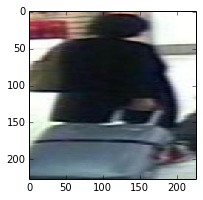

In [5]:
#query_image_path = 'rank_scripts/images_market/0004_c1s6_016996_00.jpg'
query_image_path = '/home/jayant/vision/PETA/check/0001_001.jpg'
query_image = caffe.io.load_image(query_image_path)
#query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7'][0]
plt.figure(figsize=(3,3))
plt.imshow(query_image)
print vector_query

In [6]:
#Rank Vector Setup
num_rank = 6

In [7]:
#Paired list to hold (diff,imagePath)

Rank_list= []
query_folder = '/home/jayant/vision/PETA/check/'
images_list = os.listdir(query_folder)

#print images_list

for image in images_list:
    new_net = caffe.Net(caffe_root +  'rank_scripts/multi/deploy_multinet.prototxt',
                caffe_root + 'rank_scripts/models103/_iter_500.caffemodel',
                caffe.TEST)
        
    new_net.blobs['data'].reshape(50,3,227,227)
    new_net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(query_folder + image))
    output=new_net.forward()
    vector_new=output['fc7'][0]
    diff = getDiff(vector_query, vector_new)
    
    #add the pair (diff,image) to the list
    Rank_list.append((diff,image))
    
    #sort the list based on diff
Rank_list.sort()

NewRankList = Rank_list[0:num_rank]

print NewRankList

[(0.0, '0001_001.jpg'), (214.53634159330835, '0001_002.jpg'), (367.1290657956459, '0001_003.jpg'), (476.3246436396956, '0003_001.jpg'), (507.5202570698084, '0001_004.jpg'), (531.6106463999815, '0003_002.jpg')]


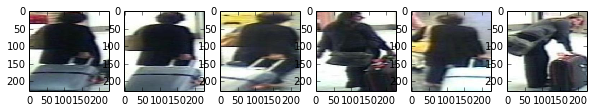

In [8]:
fig,axs = plt.subplots (nrows=1,ncols=len(NewRankList))
i=0

for item in NewRankList:
    new_image_name = item[1]
    new_image = caffe.io.load_image(query_folder + new_image_name)
    
    plt.figure(figsize=(3,3))
    axs[i].imshow(new_image)
    i=i+1